In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from alphabase.spectral_library.base import SpecLibBase
from alphadia import data, planning
from alphadia.workflow import manager, peptidecentric

import git
def get_git_root():
    git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

POOL_PROJECTS="/fs/pool/pool-mann-projects/"
POOL_MS="/Volumes/My Passport for Mac/alphadia_data/"
PROJECT_FOLDER=f"{get_git_root()}/"

RAW_FOLDER = f"{POOL_MS}"
LIBRARY_FOLDER=f"{POOL_MS}libraries/"
OUTPUT_FOLDER=f"{PROJECT_FOLDER}debugging_files/"

POOL_PROJECTS="/fs/pool/pool-mann-projects/"
POOL_MS="/fs/pool/pool-mann-ms14/"
PROJECT_FOLDER=f"{POOL_PROJECTS}despard/hpo/hpo_mse_2024_07_09/"

RAW_FOLDER = f"{POOL_MS}/Astral4/2024_07/"
LIBRARY_FOLDER=f"{PROJECT_FOLDER}libraries/"
OUTPUT_FOLDER=f"{PROJECT_FOLDER}output/"

In [5]:
import tempfile

#test_folder = tempfile.mkdtemp()

# uncomment the following line to use a specific folder
test_folder = "debugging_files"
#
# library_path
#
# raw_data_path_list = [
#   "/Users/georgwallmann/Documents/data/alphadia_performance_tests/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw",
#   "/Users/georgwallmann/Documents/data/alphadia_performance_tests/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_06.raw",
#   "/Users/georgwallmann/Documents/data/alphadia_performance_tests/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw",
# ]

# HeLa library as used in the getting started guide
library_url = "https://datashare.biochem.mpg.de/s/Uw2yfNSbApfPpTk"

# Bulk injections of HeLa cell lysate acquired on the Orbitrap Astral
raw_data_url_list = [
    "https://datashare.biochem.mpg.de/s/339jg5HtGrwLwDN/download?files=20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw",
    ]

from alphadia.test_data_downloader import DataShareDownloader

library_path = DataShareDownloader(library_url,test_folder).download()
raw_data_path_list = [DataShareDownloader(url,test_folder).download() for url in raw_data_url_list]

debugging_files/hela_hybrid.hdf does not yet exist


100% |########################################################################|


hela_hybrid.hdf successfully downloaded to debugging_files/hela_hybrid.hdf


debugging_files/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw does not yet exist


20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw successfully downloaded to debugging_files/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw


In [6]:
MODE = "astral"

if MODE == "astral":
    raw_files = [
        os.path.join(
            RAW_FOLDER,
            "20240704_OA4_Evo11_16p3min_PaSk_SA_HYE_1002575_200ng_noF_03.raw",
        )
    ]
    output_location = os.path.join(OUTPUT_FOLDER, "debugging/")
    os.makedirs(output_location, exist_ok=True)
    fasta_path_list = [os.path.join(LIBRARY_FOLDER, x) for x in ["2024_02_21_human.fasta", "2024_02_21_yeast.fasta", "2024_02_21_ecoli.fasta"]]
elif MODE == "timstof":
    raw_files = [
        os.path.join(
            performance_test_folder,
            "raw_data/timstof_lf_diap/20230502_TIMS05_PaSk_SA_HeLa_21min_diaP_12scans_S2-A3_1_2089.d",
        )
    ]
    output_location = os.path.join(
        performance_test_folder, "outputs/timstof_lf_diaPASEF"
    )
    speclib_path = os.path.join(
        performance_test_folder,
        "libraries/timstof/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_egs.hdf",
    )
else:
    raise ValueError("Unknown mode")

In [7]:
config = {
    "general": {
        "reuse_calibration": False,
        "reuse_quant": False,
        "thread_count": 10,
        "astral_ms1": False,
    },
    "search_advanced": {
        "top_k_fragments_scoring": 12,
    },
    "search": {
        "target_num_candidates": 5,
        "target_ms1_tolerance": 0.1 if MODE == "astral" else 15,
        "target_ms2_tolerance": 0.1 if MODE == "astral" else 15,
        "target_rt_tolerance": 1,
        "max_epochs" : 7,
    },
    "fdr": {"classifier": "legacy"},

    "library_prediction": {
      "predict": False,
      "enzyme": 'trypsin',
      "fixed_modifications": 'Carbamidomethyl@C',
      "variable_modifications": 'Oxidation@M;Acetyl@Protein N-term',
      "max_var_mod_num": 1,
      "missed_cleavages": 0,
      "precursor_len": [7, 35],
      "precursor_charge": [2, 4],
      "precursor_mz": [380, 980],
      "fragment_mz": [200, 2000],
      "nce": 25,
      "instrument": 'Lumos',
      "save_hdf": True,
    },
    "search_initial": {
      # Number of peak groups identified in the convolution score to classify with target decoy comeptition
      "initial_num_candidates": 1,
    
      # initial ms1 tolerance in ppm
      "initial_ms1_tolerance": 100,
    
      # initial ms2 tolerance in ppm
      "initial_ms2_tolerance": 100,
    
      # initial retention time tolerance in seconds
      "initial_rt_tolerance": 600,
    },
    "calibration":{
        "recalibration_target" : 50,
        "param_calibration_order" : [['ms2'], ['rt'], ['ms1', 'mobility']],
    }
}

#speclib_path = f"{LIBRARY_FOLDER}speclib.hdf"

In [8]:
#plan = planning.Plan(output_location, raw_files, fasta_path_list=fasta_path_list, config=config)
#plan = planning.Plan(output_location, raw_files, speclib_path, config=config)
plan = planning.Plan(test_folder, raw_data_path_list, library_path, config=config)

0:00:00.002782 PROGRESS:           _      _         ___ ___   _   
0:00:00.005688 PROGRESS:      __ _| |_ __| |_  __ _|   \_ _| /_\  
0:00:00.006413 PROGRESS:     / _` | | '_ \ ' \/ _` | |) | | / _ \ 
0:00:00.006706 PROGRESS:     \__,_|_| .__/_||_\__,_|___/___/_/ \_\
0:00:00.006996 PROGRESS:            |_|                           
0:00:00.007283 PROGRESS: 
0:00:00.007655 PROGRESS: version: 1.7.2
0:00:00.008273 PROGRESS: hostname: Oscars-MacBook-Air-4.local
0:00:00.009569 PROGRESS: date: 2024-07-19 15:03:09
0:00:00.009834 PROGRESS: =================== Environment ===================
0:00:00.010484 PROGRESS: alphatims       : 1.0.8
0:00:00.010772 PROGRESS: alpharaw        : 0.4.5
0:00:00.011061 PROGRESS: alphabase       : 1.2.5
0:00:00.011357 PROGRESS: alphapeptdeep   : 1.2.1
0:00:00.011624 PROGRESS: directlfq       : 0.2.19
0:00:00.011928 PROGRESS: ===================================================
0:00:00.012566 INFO: loading default config from /Users/odespard/projects/git/alphadia

In [9]:
for raw_name, dia_path, speclib in plan.get_run_data():
    pass

0:00:34.110482 PROGRESS: Loading raw file 1/1: 20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05


In [10]:
workflow = peptidecentric.PeptideCentricWorkflow(
    raw_name,
    plan.config,
)


0:00:34.164754 INFO: Creating parent folder for workflows at debugging_files/.progress
0:00:34.165522 INFO: Creating workflow folder for 20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05 at debugging_files/.progress/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05


Testing again!


In [11]:
workflow.load(dia_path, speclib)

49it [01:16,  1.57s/it]
0:02:05.147437 INFO: Determining DIA cycle
0:02:05.978362 INFO: Found cycle with start 0.00 min and length 301.
0:02:08.229141 INFO: ============ Raw file stats ============
0:02:08.254326 INFO: RT (min)            : 0.0 - 20.9
0:02:08.254957 INFO: RT duration (sec)   : 1253.3
0:02:08.263925 INFO: RT duration (min)   : 20.9
0:02:08.268585 INFO: Cycle len (scans)   : 301
0:02:08.269558 INFO: Cycle len (sec)     : 1.55
0:02:08.270144 INFO: Number of cycles    : 806
0:02:08.276302 INFO: MS2 range (m/z)     : 380.4 - 980.7
0:02:08.281336 INFO: ========================================
0:02:10.743414 INFO: Initializing CalibrationManager
0:02:10.746206 INFO: Loading calibration config
0:02:10.748339 INFO: Calibration config: [{'name': 'fragment', 'estimators': [{'name': 'mz', 'model': 'LOESSRegression', 'model_args': {'n_kernels': 2}, 'input_columns': ['mz_library'], 'target_columns': ['mz_observed'], 'output_columns': ['mz_calibrated'], 'transform_deviation': '1e6'}]

In [37]:
workflow.initialize_managers()

3:10:01.246978 PROGRESS: Initializing workflow 20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05
3:10:01.300898 INFO: Initializing OptimizationManager
3:10:01.301597 INFO: initial parameter: current_epoch = 0
3:10:01.301880 INFO: initial parameter: current_step = 0
3:10:01.302149 INFO: initial parameter: ms1_error = 100
3:10:01.307737 INFO: initial parameter: ms2_error = 100
3:10:01.308458 INFO: initial parameter: rt_error = 600
3:10:01.308779 INFO: initial parameter: mobility_error = 0.08
3:10:01.309119 INFO: initial parameter: column_type = library
3:10:01.309746 INFO: initial parameter: num_candidates = 1
3:10:01.310369 INFO: initial parameter: recalibration_target = 50
3:10:01.311153 INFO: initial parameter: accumulated_precursors = 0
3:10:01.311581 INFO: initial parameter: accumulated_precursors_01FDR = 0
3:10:01.311911 INFO: initial parameter: accumulated_precursors_001FDR = 0
3:10:01.312280 INFO: initial parameter: fitted_params = []
3:10:01.316235 INFO: initial parameter

Testing 2


3:10:04.301243 PROGRESS: 241,223 target precursors potentially observable (0 removed)


3:10:18.342828 INFO: Fitting ['ms2'].
3:10:18.373152 INFO: === checking if epoch conditions were reached ===
3:10:18.378018 INFO:  ms2_error      : 100.0000 > 0.1
3:10:18.380767 INFO: ❌ current_epoch  : 0 < 2
3:10:18.382172 INFO: ==============================================
3:10:18.461507 INFO: calibration group: precursor, predicting mz
3:10:18.469126 WARNING: mz prediction was skipped as it has not been fitted yet
3:10:18.471180 INFO: calibration group: precursor, predicting rt
3:10:19.631705 INFO: calibration group: fragment, predicting mz
3:10:24.408785 PROGRESS: === Epoch 0, step 0, extracting elution groups 0 to 8000 ===
3:10:25.259834 PROGRESS: Extracting batch of 15886 precursors
3:10:26.394949 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:10:26.396168 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:10:26.400802 INFO: FWHM in RT is 3.11 seconds, sigma is 0.42
3:10:26.401341 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:10:26.6006

Using base classifier


100%|██████████| 2/2 [00:00<00:00, 24966.10it/s]
3:10:49.806422 INFO: Test AUC: 0.601
3:10:49.818953 INFO: Train AUC: 0.605
3:10:49.819383 INFO: AUC difference: 0.60%


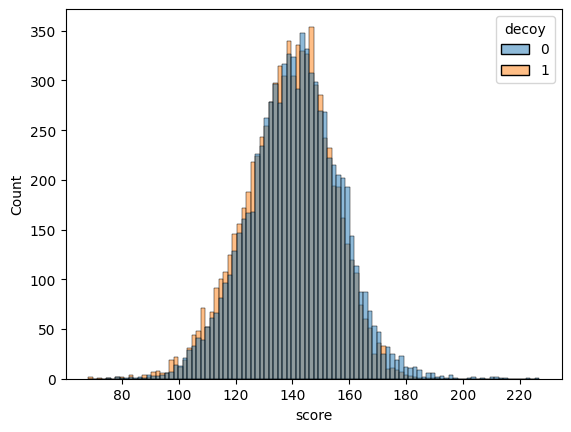

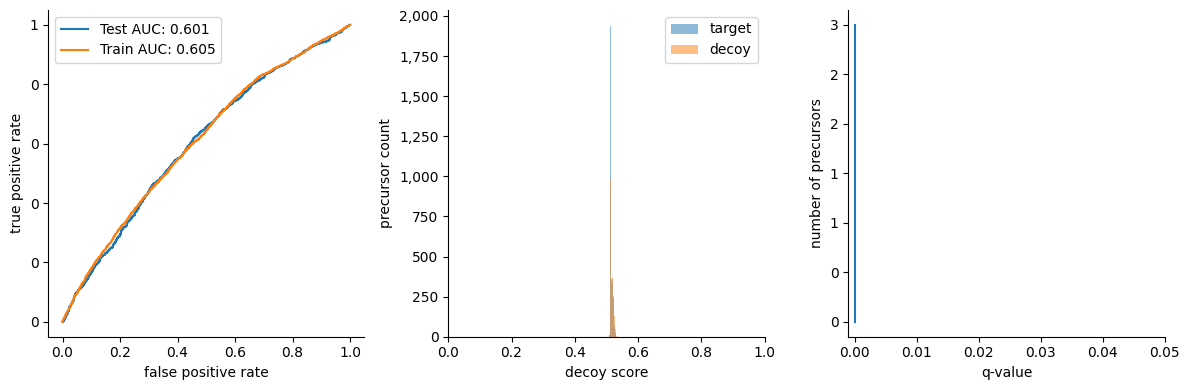

3:10:52.071410 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:10:52.096397 PROGRESS: ============================= Precursor FDR =============================
3:10:52.097547 PROGRESS: Total precursors accumulated: 4
3:10:52.098315 PROGRESS: Target precursors: 4 (100.00%)
3:10:52.100124 PROGRESS: Decoy precursors: 0 (0.00%)
3:10:52.101026 PROGRESS: 
3:10:52.106054 PROGRESS: Precursor Summary:
3:10:52.112116 PROGRESS: Channel   0:	 0.05 FDR:     4; 0.01 FDR:     4; 0.001 FDR:     4
3:10:52.113299 PROGRESS: 
3:10:52.119063 PROGRESS: Protein Summary:
3:10:52.126128 PROGRESS: Channel   0:	 0.05 FDR:     4; 0.01 FDR:     4; 0.001 FDR:     4
3:10:52.128536 PROGRESS: =========================================================================
3:10:52.140908 PROGRESS: === Epoch 0, step 1, extracting elution groups 8000 to 24000 ===


Storing classifier: 1dbbc056e05895b0


3:10:52.700759 PROGRESS: Extracting batch of 31771 precursors
3:10:52.832709 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:10:52.836098 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:10:52.836689 INFO: FWHM in RT is 3.11 seconds, sigma is 0.42
3:10:52.837094 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:10:52.869233 INFO: Starting candidate selection
100%|██████████| 31771/31771 [00:31<00:00, 1022.96it/s]
3:11:26.507814 INFO: Starting candidate scoring
100%|██████████| 31771/31771 [00:02<00:00, 12968.20it/s]
3:11:30.872403 INFO: Finished candidate processing
3:11:30.886412 INFO: Collecting candidate features
3:11:43.304400 INFO: Collecting fragment features
3:11:43.872384 INFO: Finished candidate scoring
3:11:47.989964 PROGRESS: === Epoch 0, step 1, extracted 31771 precursors and 361433 fragments ===
3:11:48.019829 INFO: performing precursor FDR with 47 features
3:11:48.020496 INFO: Decoy channel: -1
3:11:48.020884 INFO: Competetive: True

Using classifier: 1dbbc056e05895b0


100%|██████████| 299/299 [00:00<00:00, 22051.61it/s]
3:11:51.673656 INFO: Test AUC: 0.621
3:11:51.675292 INFO: Train AUC: 0.634
3:11:51.675722 INFO: AUC difference: 2.04%


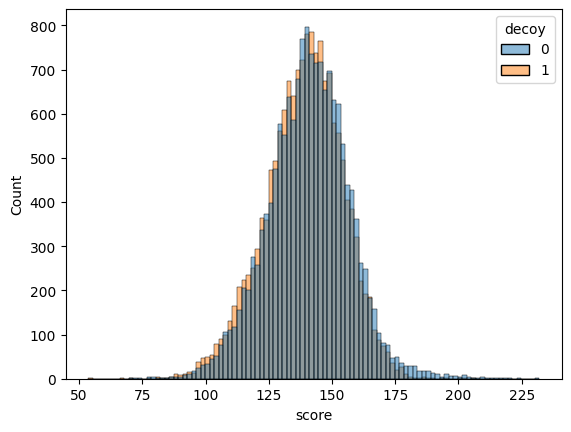

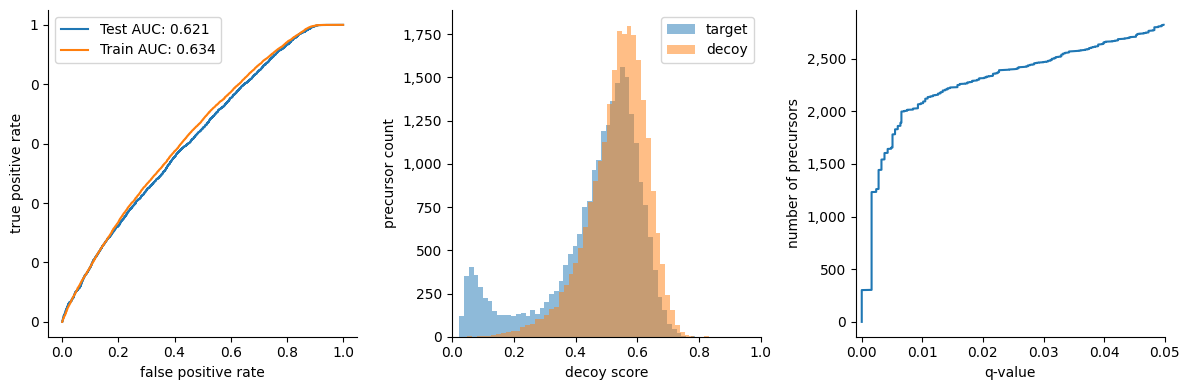

3:11:52.633229 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:11:52.636595 PROGRESS: ============================= Precursor FDR =============================
3:11:52.637266 PROGRESS: Total precursors accumulated: 3,264
3:11:52.637854 PROGRESS: Target precursors: 3,004 (92.03%)
3:11:52.638461 PROGRESS: Decoy precursors: 260 (7.97%)
3:11:52.639026 PROGRESS: 
3:11:52.639582 PROGRESS: Precursor Summary:
3:11:52.645005 PROGRESS: Channel   0:	 0.05 FDR: 2,689; 0.01 FDR: 2,057; 0.001 FDR:   303
3:11:52.646953 PROGRESS: 
3:11:52.648604 PROGRESS: Protein Summary:
3:11:52.656727 PROGRESS: Channel   0:	 0.05 FDR: 1,761; 0.01 FDR: 1,396; 0.001 FDR:   279
3:11:52.657715 PROGRESS: =========================================================================
3:11:52.713679 INFO: calibration group: fragment, fitting mz estimator 


Storing classifier: 1dbbc056e05895b0
fragments_df_filtered: 500


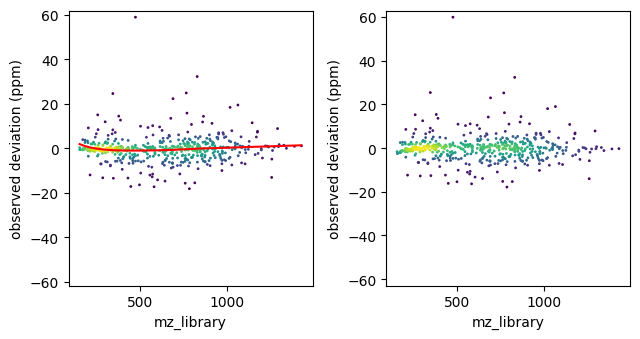

3:11:52.994896 INFO: === checking if epoch conditions were reached ===
3:11:52.995721 INFO:  ms2_error      : 22.6240 > 0.1
3:11:52.996425 INFO: ❌ current_epoch  : 0 < 2
3:11:52.997085 INFO: ==============================================
3:11:52.997812 INFO: calibration group: precursor, predicting mz
3:11:52.998403 WARNING: mz prediction was skipped as it has not been fitted yet
3:11:52.998817 INFO: calibration group: precursor, predicting rt


score cutoff 98.23164813232422


3:11:53.579589 INFO: calibration group: fragment, predicting mz
3:11:55.290662 PROGRESS: === Epoch 1, step 0, extracting elution groups 0 to 24000 ===
3:11:55.876773 PROGRESS: Extracting batch of 47657 precursors
3:11:55.958096 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:11:55.958878 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:11:55.960816 INFO: FWHM in RT is 3.84 seconds, sigma is 0.52
3:11:55.961633 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:11:55.980652 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:35<00:00, 1344.19it/s]
3:12:37.120633 INFO: Starting candidate scoring
100%|██████████| 238275/238275 [00:16<00:00, 14751.42it/s]
3:13:01.175777 INFO: Finished candidate processing
3:13:01.189519 INFO: Collecting candidate features
3:13:06.888798 WARNING: intensity_correlation has 3 NaNs ( 0.00 % out of 238270)
3:13:06.946140 INFO: Collecting fragment features
3:13:07.758080 INFO: Finished candidate scoring
3:13

Using classifier: 1dbbc056e05895b0


3:13:10.359205 WARNING: dropped 1 target PSMs due to missing features
3:13:10.361850 WARNING: dropped 2 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 21732.52it/s]
3:13:22.154697 INFO: Test AUC: 0.616
3:13:22.157527 INFO: Train AUC: 0.624
3:13:22.157857 INFO: AUC difference: 1.27%


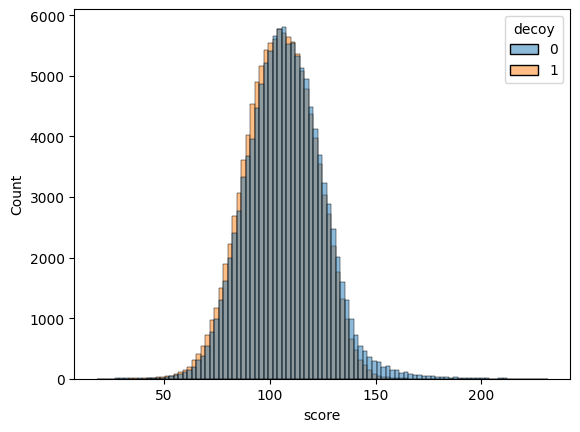

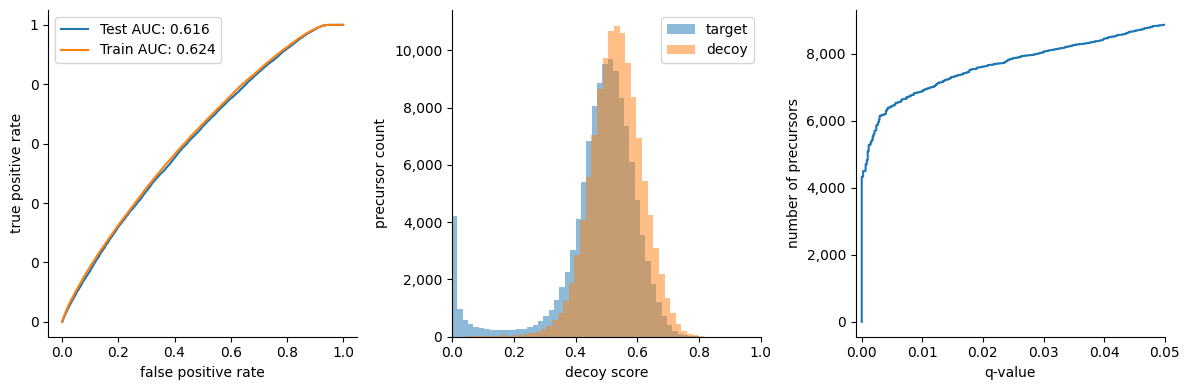

3:13:24.267477 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:13:24.274175 PROGRESS: ============================= Precursor FDR =============================
3:13:24.275123 PROGRESS: Total precursors accumulated: 9,278
3:13:24.276124 PROGRESS: Target precursors: 8,751 (94.32%)
3:13:24.277310 PROGRESS: Decoy precursors: 527 (5.68%)
3:13:24.278005 PROGRESS: 
3:13:24.278565 PROGRESS: Precursor Summary:
3:13:24.289404 PROGRESS: Channel   0:	 0.05 FDR: 8,435; 0.01 FDR: 6,807; 0.001 FDR: 5,081
3:13:24.290261 PROGRESS: 
3:13:24.290864 PROGRESS: Protein Summary:
3:13:24.301165 PROGRESS: Channel   0:	 0.05 FDR: 4,351; 0.01 FDR: 3,715; 0.001 FDR: 3,023
3:13:24.302058 PROGRESS: =========================================================================


Storing classifier: 03a2f02d595f0537


3:13:24.740445 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


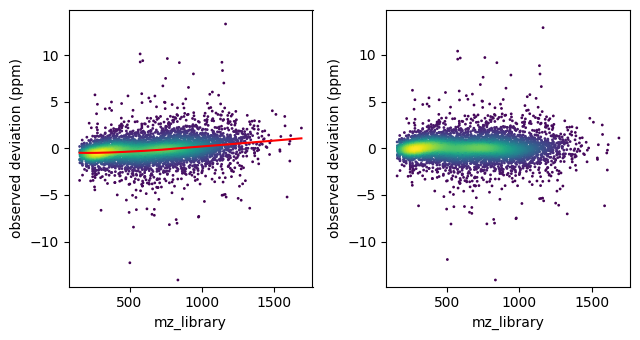

3:13:25.676008 INFO: === checking if epoch conditions were reached ===
3:13:25.677652 INFO:  ms2_error      : 5.7725 > 0.1
3:13:25.679077 INFO: ❌ current_epoch  : 1 < 2
3:13:25.679755 INFO: ==============================================
3:13:25.680834 INFO: calibration group: precursor, predicting mz
3:13:25.681529 WARNING: mz prediction was skipped as it has not been fitted yet
3:13:25.681921 INFO: calibration group: precursor, predicting rt


score cutoff 76.85371884155273


3:13:26.060393 INFO: calibration group: fragment, predicting mz
3:13:27.673278 PROGRESS: === Epoch 2, step 0, extracting elution groups 0 to 24000 ===
3:13:28.079776 PROGRESS: Extracting batch of 47657 precursors
3:13:28.152719 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:13:28.153725 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:13:28.154212 INFO: FWHM in RT is 3.48 seconds, sigma is 0.48
3:13:28.155172 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:13:28.163629 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:51<00:00, 920.83it/s] 
3:15:31.837780 INFO: Starting candidate scoring
100%|██████████| 238275/238275 [00:15<00:00, 15090.40it/s]
3:15:51.514107 INFO: Finished candidate processing
3:15:51.526979 INFO: Collecting candidate features
3:15:54.306674 WARNING: intensity_correlation has 62 NaNs ( 0.03 % out of 237902)
3:15:54.390355 INFO: Collecting fragment features
3:15:55.490798 INFO: Finished candidate scoring
3:1

Using classifier: 1dbbc056e05895b0


3:16:01.597156 WARNING: dropped 32 target PSMs due to missing features
3:16:01.600674 WARNING: dropped 30 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 22197.57it/s]
3:16:12.105399 INFO: Test AUC: 0.628
3:16:12.106803 INFO: Train AUC: 0.633
3:16:12.107225 INFO: AUC difference: 0.90%


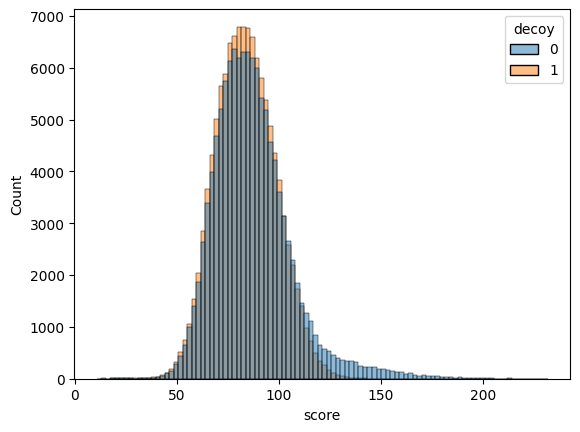

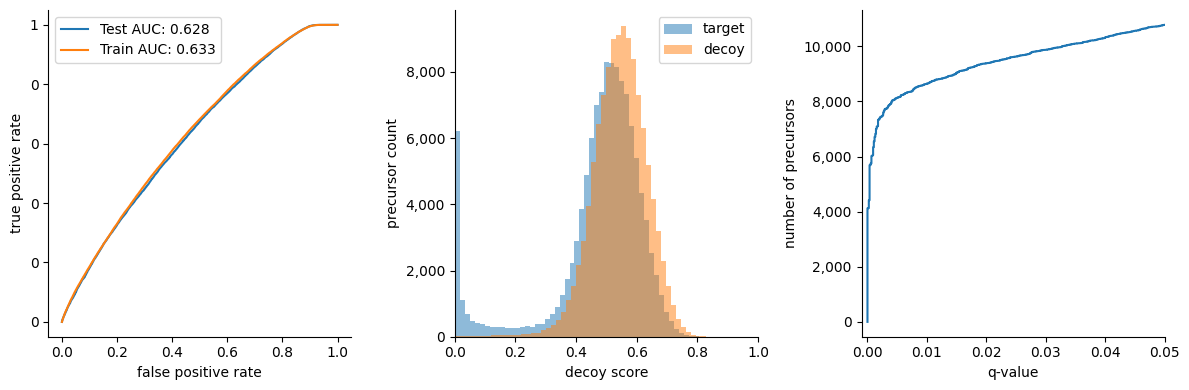

3:16:14.382892 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:16:14.393674 PROGRESS: ============================= Precursor FDR =============================
3:16:14.394808 PROGRESS: Total precursors accumulated: 10,848
3:16:14.395619 PROGRESS: Target precursors: 10,312 (95.06%)
3:16:14.396309 PROGRESS: Decoy precursors: 536 (4.94%)
3:16:14.397248 PROGRESS: 
3:16:14.398557 PROGRESS: Precursor Summary:
3:16:14.410468 PROGRESS: Channel   0:	 0.05 FDR: 10,267; 0.01 FDR: 8,559; 0.001 FDR: 6,331
3:16:14.412051 PROGRESS: 
3:16:14.413128 PROGRESS: Protein Summary:
3:16:14.428815 PROGRESS: Channel   0:	 0.05 FDR: 4,930; 0.01 FDR: 4,364; 0.001 FDR: 3,540
3:16:14.429750 PROGRESS: =========================================================================


Storing classifier: 48aa7ecdb550b9c3


3:16:14.685867 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


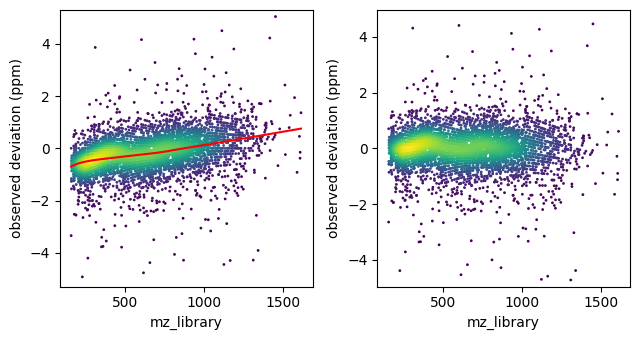

3:16:15.640852 INFO: === checking if epoch conditions were reached ===
3:16:15.642128 INFO:  ms2_error      : 2.7937 > 0.1
3:16:15.643531 INFO: ✅ current_epoch  : 2 >= 2
3:16:15.644438 INFO: ==============================================
3:16:15.653239 INFO: calibration group: precursor, predicting mz
3:16:15.654768 WARNING: mz prediction was skipped as it has not been fitted yet
3:16:15.657198 INFO: calibration group: precursor, predicting rt


score cutoff 62.19186799621582


3:16:15.991663 INFO: calibration group: fragment, predicting mz
3:16:17.629075 PROGRESS: === Epoch 3, step 0, extracting elution groups 0 to 24000 ===
3:16:19.691919 PROGRESS: Extracting batch of 47657 precursors
3:16:19.972168 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:16:19.982186 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:16:19.983079 INFO: FWHM in RT is 3.02 seconds, sigma is 0.41
3:16:19.983399 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:16:20.022417 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:29<00:00, 1632.06it/s]
3:16:57.794796 INFO: Starting candidate scoring
100%|██████████| 238275/238275 [00:29<00:00, 8030.94it/s] 
3:17:34.246214 INFO: Finished candidate processing
3:17:34.272847 INFO: Collecting candidate features
3:17:42.109628 WARNING: intensity_correlation has 802 NaNs ( 0.34 % out of 234030)
3:17:42.179136 INFO: Collecting fragment features
3:17:43.437718 INFO: Finished candidate scoring
3:

Using classifier: 1dbbc056e05895b0


3:17:51.673932 WARNING: dropped 411 target PSMs due to missing features
3:17:51.720471 WARNING: dropped 391 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 22104.76it/s]
3:18:03.538193 INFO: Test AUC: 0.615
3:18:03.539137 INFO: Train AUC: 0.626
3:18:03.539727 INFO: AUC difference: 1.83%


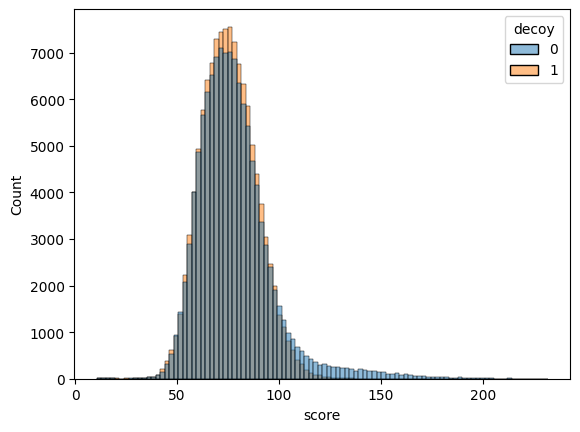

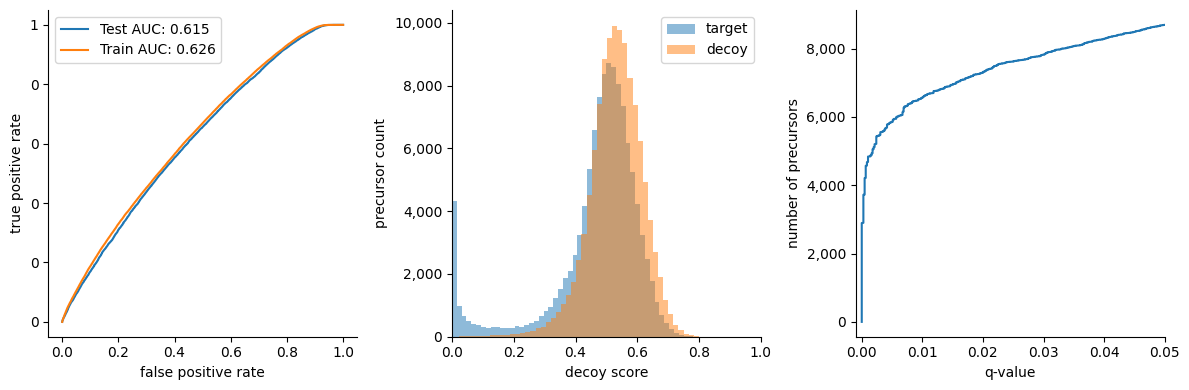

3:18:05.119706 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:18:05.133158 PROGRESS: ============================= Precursor FDR =============================
3:18:05.134811 PROGRESS: Total precursors accumulated: 9,078
3:18:05.135682 PROGRESS: Target precursors: 8,566 (94.36%)
3:18:05.137061 PROGRESS: Decoy precursors: 512 (5.64%)
3:18:05.138062 PROGRESS: 
3:18:05.139227 PROGRESS: Precursor Summary:
3:18:05.157489 PROGRESS: Channel   0:	 0.05 FDR: 8,281; 0.01 FDR: 6,504; 0.001 FDR: 4,673
3:18:05.158441 PROGRESS: 
3:18:05.159022 PROGRESS: Protein Summary:
3:18:05.171023 PROGRESS: Channel   0:	 0.05 FDR: 4,275; 0.01 FDR: 3,583; 0.001 FDR: 2,832
3:18:05.172835 PROGRESS: =========================================================================


Storing classifier: 6bdd73c377b402e5


3:18:05.408159 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


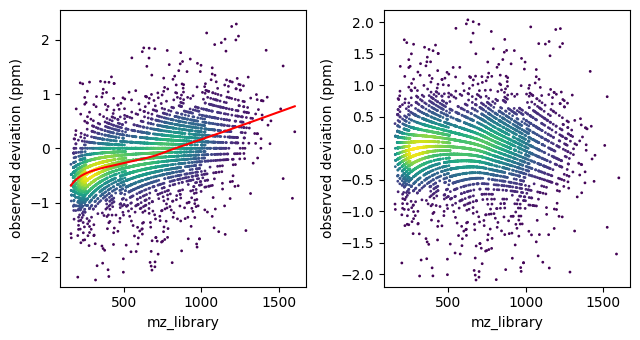

3:18:06.400920 INFO: === checking if epoch conditions were reached ===
3:18:06.402514 INFO:  ms2_error      : 1.7954 > 0.1
3:18:06.404168 INFO: ✅ current_epoch  : 3 >= 2
3:18:06.404949 INFO: ==============================================


score cutoff 58.774738788604736


3:18:53.832266 PROGRESS: Optimal value for ms2 is 5.77.
3:19:06.170507 INFO: Fitting ['rt'].
3:19:06.187027 INFO: === checking if epoch conditions were reached ===
3:19:06.189460 INFO:  rt_error       : 600.0000 > 1
3:19:06.190900 INFO: ❌ current_epoch  : 0 < 2
3:19:06.192207 INFO: ==============================================
3:19:08.778451 INFO: calibration group: precursor, predicting mz
3:19:08.782364 WARNING: mz prediction was skipped as it has not been fitted yet
3:19:08.786935 INFO: calibration group: precursor, predicting rt
3:19:09.731842 INFO: calibration group: fragment, predicting mz
3:19:12.487134 PROGRESS: === Epoch 0, step 0, extracting elution groups 0 to 24000 ===
3:19:14.121769 PROGRESS: Extracting batch of 47657 precursors
3:19:14.615839 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:19:14.619878 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:19:14.625907 INFO: FWHM in RT is 2.55 seconds, sigma is 0.35
3:19:14.630807 INFO: FWHM 

Using classifier: 48aa7ecdb550b9c3


3:20:52.922134 WARNING: dropped 29 target PSMs due to missing features
3:20:52.923315 WARNING: dropped 30 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 21987.72it/s]
3:21:05.738826 INFO: Test AUC: 0.628
3:21:05.741236 INFO: Train AUC: 0.642
3:21:05.741659 INFO: AUC difference: 2.26%


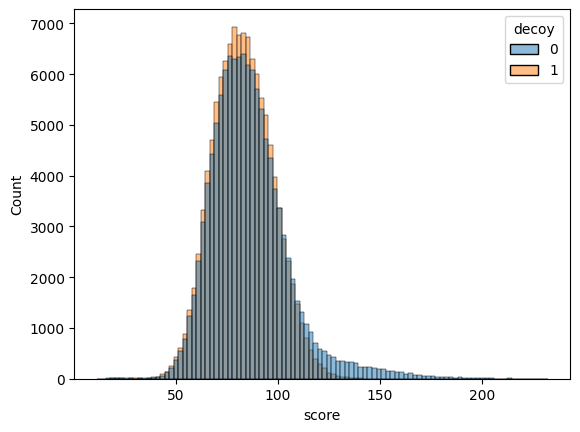

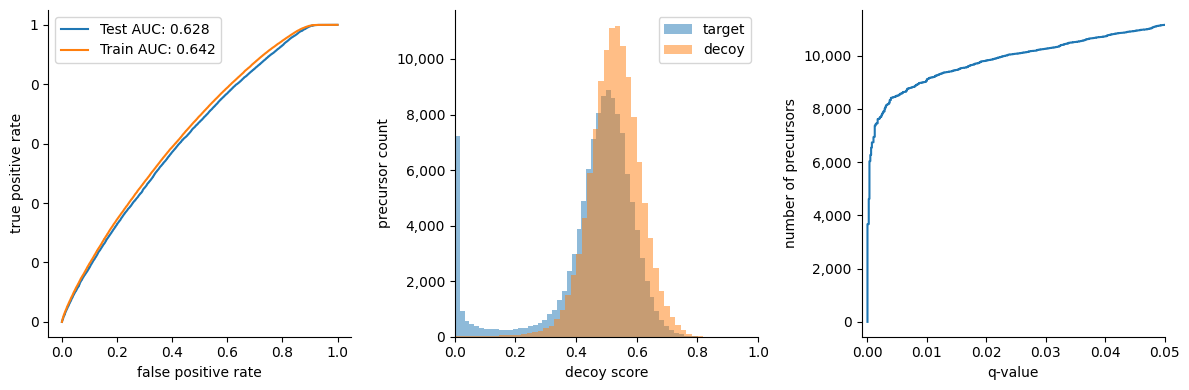

3:21:07.579843 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:21:07.589028 PROGRESS: ============================= Precursor FDR =============================
3:21:07.589929 PROGRESS: Total precursors accumulated: 11,359
3:21:07.590559 PROGRESS: Target precursors: 10,773 (94.84%)
3:21:07.591548 PROGRESS: Decoy precursors: 586 (5.16%)
3:21:07.592109 PROGRESS: 
3:21:07.592838 PROGRESS: Precursor Summary:
3:21:07.609608 PROGRESS: Channel   0:	 0.05 FDR: 10,621; 0.01 FDR: 9,016; 0.001 FDR: 6,735
3:21:07.610842 PROGRESS: 
3:21:07.611566 PROGRESS: Protein Summary:
3:21:07.626557 PROGRESS: Channel   0:	 0.05 FDR: 5,065; 0.01 FDR: 4,522; 0.001 FDR: 3,667
3:21:07.627444 PROGRESS: =========================================================================


Storing classifier: aa8ddcf2c1f86174


3:21:07.952570 INFO: calibration group: precursor, fitting rt estimator 


fragments_df_filtered: 5000


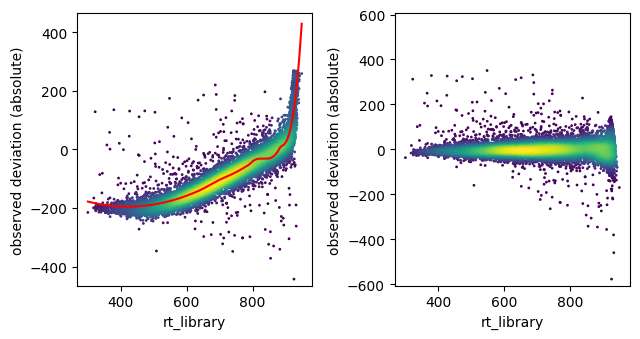

3:21:10.224018 INFO: === checking if epoch conditions were reached ===
3:21:10.225861 INFO:  rt_error       : 165.3605 > 1
3:21:10.228617 INFO: ❌ current_epoch  : 0 < 2
3:21:10.229832 INFO: ==============================================


score cutoff 57.937267265319825


3:22:12.504083 INFO: calibration group: precursor, predicting mz
3:22:12.520803 WARNING: mz prediction was skipped as it has not been fitted yet
3:22:12.522406 INFO: calibration group: precursor, predicting rt
3:22:13.103659 INFO: calibration group: fragment, predicting mz
3:22:15.041556 PROGRESS: === Epoch 1, step 0, extracting elution groups 0 to 24000 ===
3:22:15.888182 PROGRESS: Extracting batch of 47657 precursors
3:22:16.103453 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:22:16.104997 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:22:16.107050 INFO: FWHM in RT is 2.96 seconds, sigma is 0.40
3:22:16.108257 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:22:16.145852 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:17<00:00, 2794.64it/s]
3:22:37.044153 INFO: Starting candidate scoring
100%|██████████| 238271/238271 [00:13<00:00, 17110.14it/s]
3:22:56.938999 INFO: Finished candidate processing
3:22:56.954802 INFO: Col

Using classifier: 48aa7ecdb550b9c3


3:23:08.573843 WARNING: dropped 249 target PSMs due to missing features
3:23:08.605745 WARNING: dropped 242 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 21539.07it/s]
3:23:20.345953 INFO: Test AUC: 0.638
3:23:20.349607 INFO: Train AUC: 0.649
3:23:20.350042 INFO: AUC difference: 1.58%


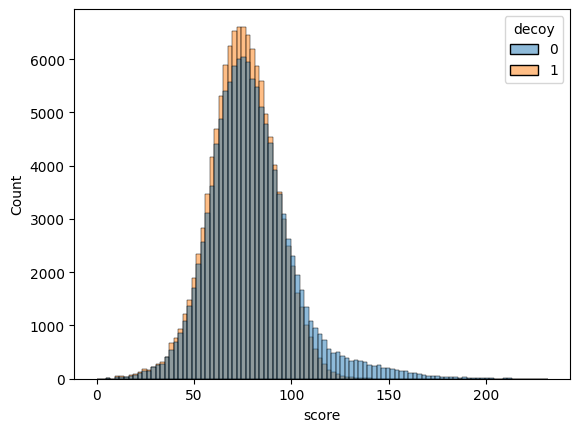

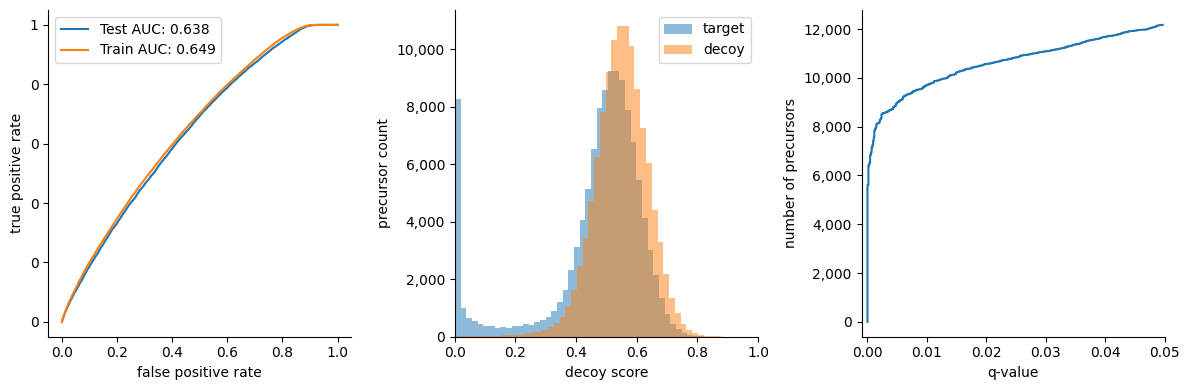

3:23:22.244327 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:23:22.257703 PROGRESS: ============================= Precursor FDR =============================
3:23:22.260228 PROGRESS: Total precursors accumulated: 12,174
3:23:22.261639 PROGRESS: Target precursors: 11,598 (95.27%)
3:23:22.264684 PROGRESS: Decoy precursors: 576 (4.73%)
3:23:22.265857 PROGRESS: 
3:23:22.268361 PROGRESS: Precursor Summary:
3:23:22.285957 PROGRESS: Channel   0:	 0.05 FDR: 11,598; 0.01 FDR: 9,609; 0.001 FDR: 7,407
3:23:22.286946 PROGRESS: 
3:23:22.287609 PROGRESS: Protein Summary:
3:23:22.313066 PROGRESS: Channel   0:	 0.05 FDR: 5,337; 0.01 FDR: 4,699; 0.001 FDR: 3,926
3:23:22.314629 PROGRESS: =========================================================================


Storing classifier: 7e782950ab178d82


3:23:23.170807 INFO: calibration group: precursor, fitting rt estimator 


fragments_df_filtered: 5000


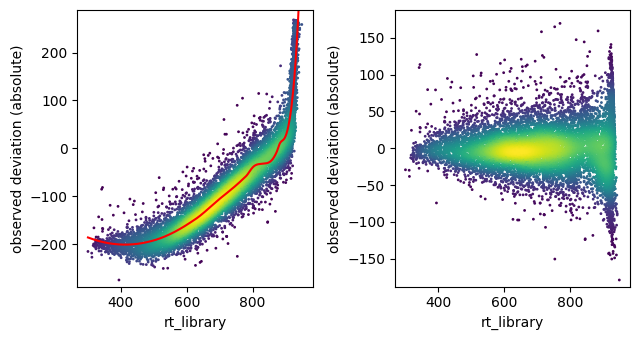

3:23:25.849649 INFO: === checking if epoch conditions were reached ===
3:23:25.850713 INFO:  rt_error       : 118.1829 > 1
3:23:25.851398 INFO: ❌ current_epoch  : 1 < 2
3:23:25.852024 INFO: ==============================================
3:23:25.854312 INFO: calibration group: precursor, predicting mz
3:23:25.854916 WARNING: mz prediction was skipped as it has not been fitted yet
3:23:25.855260 INFO: calibration group: precursor, predicting rt


score cutoff 45.19101959228516


3:23:26.255940 INFO: calibration group: fragment, predicting mz
3:23:27.971601 PROGRESS: === Epoch 2, step 0, extracting elution groups 0 to 24000 ===
3:23:28.383611 PROGRESS: Extracting batch of 47657 precursors
3:23:28.481166 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:23:28.481830 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:23:28.482584 INFO: FWHM in RT is 2.93 seconds, sigma is 0.40
3:23:28.483043 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:23:28.506585 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:09<00:00, 5254.56it/s]
3:23:40.207639 INFO: Starting candidate scoring
100%|██████████| 238256/238256 [00:21<00:00, 11335.42it/s]
3:24:04.915288 INFO: Finished candidate processing
3:24:04.965652 INFO: Collecting candidate features
3:24:10.819299 WARNING: intensity_correlation has 699 NaNs ( 0.30 % out of 231685)
3:24:10.924346 INFO: Collecting fragment features
3:24:15.776155 INFO: Finished candidate scoring
3:

Using classifier: 48aa7ecdb550b9c3


3:24:30.267432 WARNING: dropped 335 target PSMs due to missing features
3:24:30.275907 WARNING: dropped 364 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 22335.08it/s]
3:24:48.334496 INFO: Test AUC: 0.639
3:24:48.362529 INFO: Train AUC: 0.649
3:24:48.363627 INFO: AUC difference: 1.52%


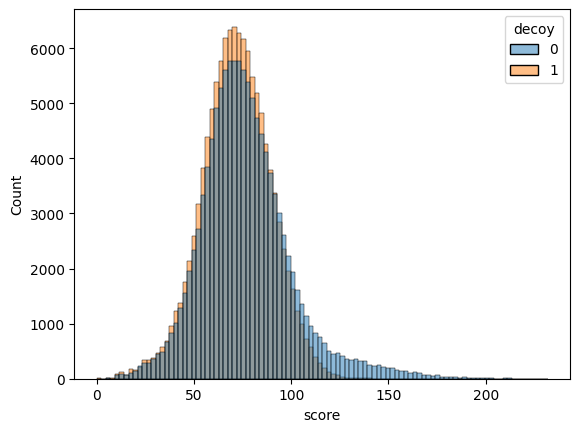

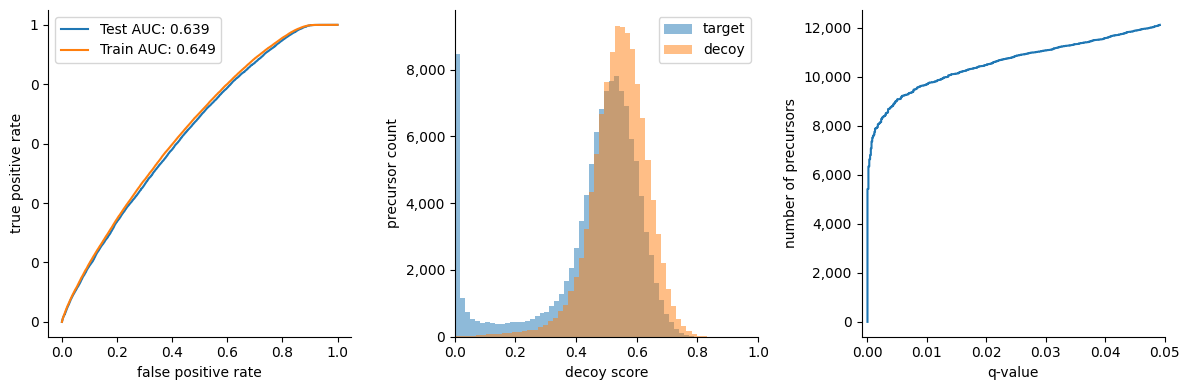

Storing classifier: 85190c6996626757


3:24:55.969504 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:24:56.031936 PROGRESS: ============================= Precursor FDR =============================
3:24:56.037129 PROGRESS: Total precursors accumulated: 12,117
3:24:56.039879 PROGRESS: Target precursors: 11,549 (95.31%)
3:24:56.041837 PROGRESS: Decoy precursors: 568 (4.69%)
3:24:56.046114 PROGRESS: 
3:24:56.049387 PROGRESS: Precursor Summary:
3:24:56.107306 PROGRESS: Channel   0:	 0.05 FDR: 11,549; 0.01 FDR: 9,591; 0.001 FDR: 7,572
3:24:56.108164 PROGRESS: 
3:24:56.110985 PROGRESS: Protein Summary:
3:24:56.182902 PROGRESS: Channel   0:	 0.05 FDR: 5,330; 0.01 FDR: 4,703; 0.001 FDR: 3,998
3:24:56.185087 PROGRESS: =========================================================================
3:24:56.950111 INFO: calibration group: precursor, fitting rt estimator 


fragments_df_filtered: 5000


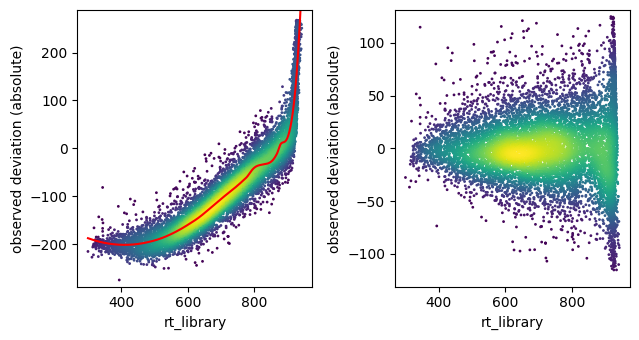

3:24:59.464409 INFO: === checking if epoch conditions were reached ===
3:24:59.469585 INFO:  rt_error       : 109.2228 > 1
3:24:59.470566 INFO: ✅ current_epoch  : 2 >= 2
3:24:59.471140 INFO: ==============================================


score cutoff 43.99731021881104


3:26:21.785459 PROGRESS: Optimal value for rt is 165.36.
3:26:28.379889 INFO: Fitting ['ms1', 'mobility'].
3:26:28.384450 INFO: === checking if epoch conditions were reached ===
3:26:28.386091 INFO:  ms1_error      : 100.0000 > 0.1
3:26:28.390119 INFO: ❌ current_epoch  : 0 < 2
3:26:28.393308 INFO: ==============================================
3:26:28.405208 INFO: calibration group: precursor, predicting mz
3:26:28.413541 WARNING: mz prediction was skipped as it has not been fitted yet
3:26:28.421604 INFO: calibration group: precursor, predicting rt
3:26:29.715724 INFO: calibration group: fragment, predicting mz
3:26:33.427830 PROGRESS: === Epoch 0, step 0, extracting elution groups 0 to 24000 ===
3:26:35.943819 PROGRESS: Extracting batch of 47657 precursors
3:26:37.476481 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:26:37.548243 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:26:37.606749 INFO: FWHM in RT is 2.92 seconds, sigma is 0.40
3:26:37.60

Using classifier: 7e782950ab178d82


3:27:30.796083 WARNING: dropped 255 target PSMs due to missing features
3:27:30.797594 WARNING: dropped 243 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 22243.87it/s]
3:27:46.433949 INFO: Test AUC: 0.642
3:27:46.438463 INFO: Train AUC: 0.654
3:27:46.438950 INFO: AUC difference: 1.77%


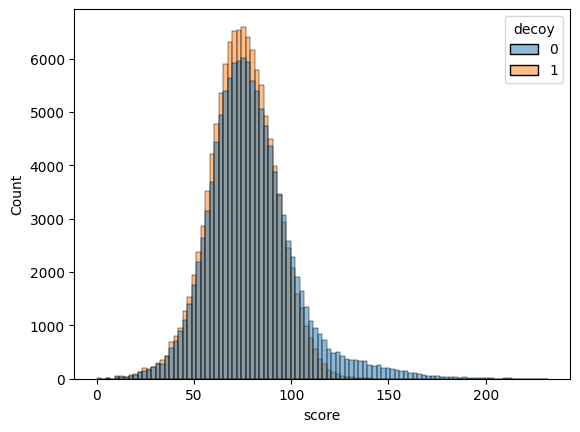

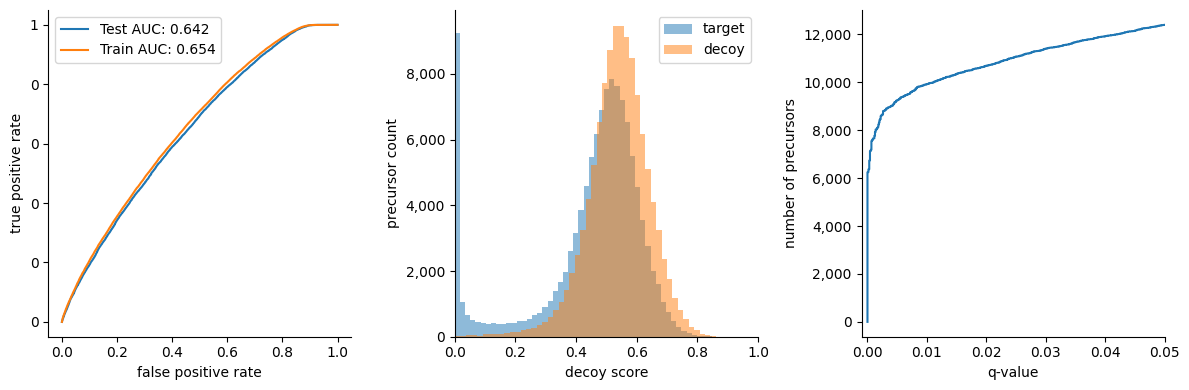

3:27:48.212288 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:27:48.221623 PROGRESS: ============================= Precursor FDR =============================
3:27:48.222506 PROGRESS: Total precursors accumulated: 12,482
3:27:48.223438 PROGRESS: Target precursors: 11,869 (95.09%)
3:27:48.223999 PROGRESS: Decoy precursors: 613 (4.91%)
3:27:48.225102 PROGRESS: 
3:27:48.225832 PROGRESS: Precursor Summary:
3:27:48.259535 PROGRESS: Channel   0:	 0.05 FDR: 11,808; 0.01 FDR: 9,823; 0.001 FDR: 7,648
3:27:48.261412 PROGRESS: 
3:27:48.262695 PROGRESS: Protein Summary:
3:27:48.299090 PROGRESS: Channel   0:	 0.05 FDR: 5,424; 0.01 FDR: 4,763; 0.001 FDR: 4,022
3:27:48.300368 PROGRESS: =========================================================================


Storing classifier: 1f6acbc091d1164c


3:27:48.761562 INFO: calibration group: precursor, fitting mz estimator 


fragments_df_filtered: 5000


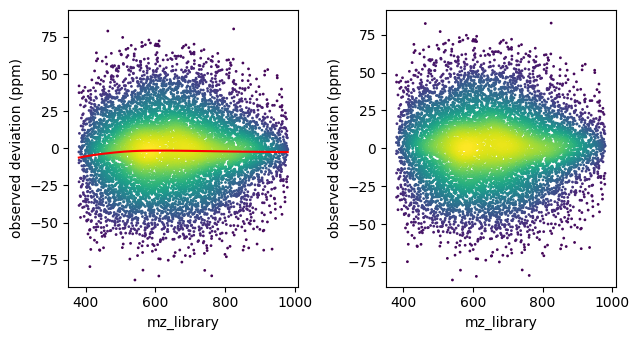

3:27:51.162918 INFO: === checking if epoch conditions were reached ===
3:27:51.165879 INFO:  ms1_error      : 69.6110 > 0.1
3:27:51.167894 INFO: ❌ current_epoch  : 0 < 2
3:27:51.169513 INFO: ==============================================
3:27:51.172160 INFO: calibration group: precursor, predicting mz


score cutoff 42.13803169250488


3:27:51.429380 INFO: calibration group: precursor, predicting rt
3:27:51.803313 INFO: calibration group: fragment, predicting mz
3:27:53.699345 PROGRESS: === Epoch 1, step 0, extracting elution groups 0 to 24000 ===
3:27:54.283967 PROGRESS: Extracting batch of 47657 precursors
3:27:54.530706 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:27:54.531635 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:27:54.533005 INFO: FWHM in RT is 2.91 seconds, sigma is 0.40
3:27:54.533585 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:27:54.559283 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:12<00:00, 3820.82it/s]
3:28:10.267791 INFO: Starting candidate scoring
100%|██████████| 238269/238269 [00:13<00:00, 17167.57it/s]
3:28:32.076047 INFO: Finished candidate processing
3:28:32.086545 INFO: Collecting candidate features
3:28:39.781551 WARNING: intensity_correlation has 529 NaNs ( 0.23 % out of 233507)
3:28:40.521700 INFO: Collecting fra

Using classifier: 7e782950ab178d82


3:28:46.536313 WARNING: dropped 250 target PSMs due to missing features
3:28:46.539131 WARNING: dropped 279 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 22135.48it/s]
3:28:56.016186 INFO: Test AUC: 0.641
3:28:56.019311 INFO: Train AUC: 0.652
3:28:56.020091 INFO: AUC difference: 1.72%


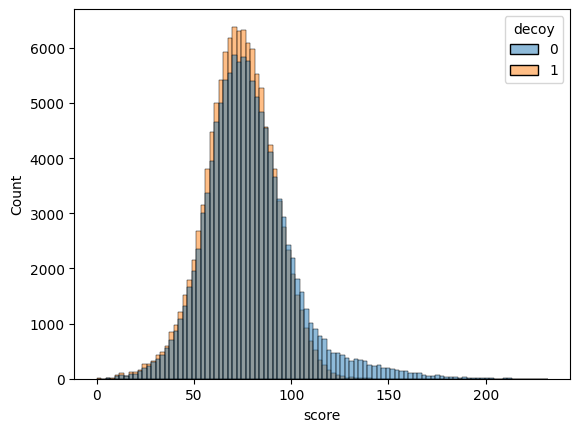

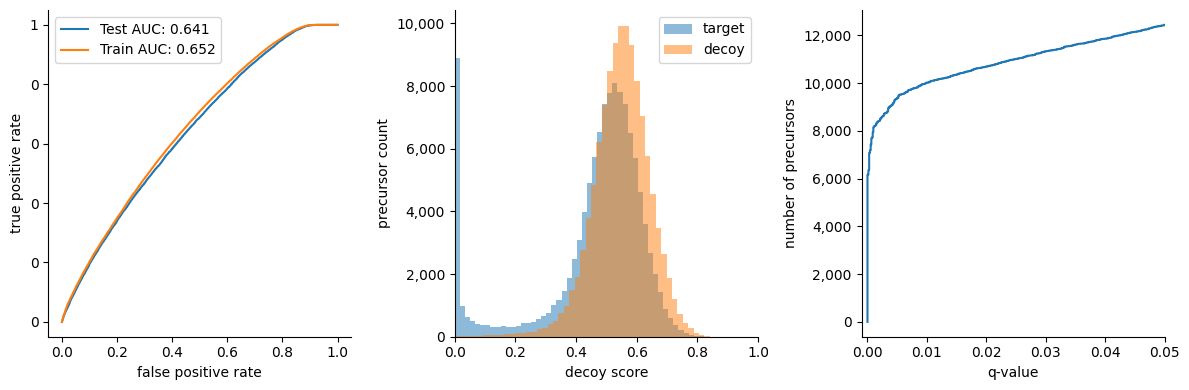

3:28:57.951249 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
3:28:57.978023 PROGRESS: ============================= Precursor FDR =============================
3:28:57.979516 PROGRESS: Total precursors accumulated: 12,522
3:28:57.982773 PROGRESS: Target precursors: 11,901 (95.04%)
3:28:57.983651 PROGRESS: Decoy precursors: 621 (4.96%)
3:28:57.984480 PROGRESS: 
3:28:57.987999 PROGRESS: Precursor Summary:
3:28:58.023615 PROGRESS: Channel   0:	 0.05 FDR: 11,844; 0.01 FDR: 9,912; 0.001 FDR: 8,139
3:28:58.025134 PROGRESS: 
3:28:58.026155 PROGRESS: Protein Summary:
3:28:58.047360 PROGRESS: Channel   0:	 0.05 FDR: 5,409; 0.01 FDR: 4,795; 0.001 FDR: 4,216
3:28:58.049382 PROGRESS: =========================================================================


Storing classifier: 9d3e05382286d155


3:28:58.536691 INFO: calibration group: precursor, fitting mz estimator 


fragments_df_filtered: 5000


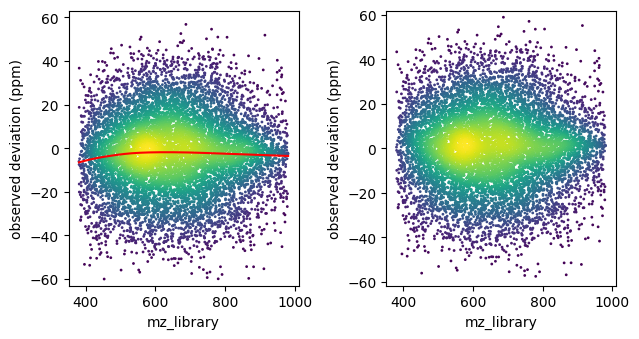

3:29:01.228523 INFO: === checking if epoch conditions were reached ===
3:29:01.229602 INFO:  ms1_error      : 49.2017 > 0.1
3:29:01.230331 INFO: ❌ current_epoch  : 1 < 2
3:29:01.231027 INFO: ==============================================
3:29:01.233709 INFO: calibration group: precursor, predicting mz


score cutoff 34.76584114456177


3:29:01.436364 INFO: calibration group: precursor, predicting rt
3:29:01.784285 INFO: calibration group: fragment, predicting mz
3:29:03.774835 PROGRESS: === Epoch 2, step 0, extracting elution groups 0 to 24000 ===
3:29:05.111015 PROGRESS: Extracting batch of 47657 precursors
3:29:05.236872 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
3:29:05.237543 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
3:29:05.238848 INFO: FWHM in RT is 2.90 seconds, sigma is 0.40
3:29:05.239287 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
3:29:05.249940 INFO: Starting candidate selection
100%|██████████| 47657/47657 [00:12<00:00, 3683.09it/s]
3:29:23.854361 INFO: Starting candidate scoring
100%|██████████| 238271/238271 [00:21<00:00, 11251.56it/s]
3:29:47.489910 INFO: Finished candidate processing
3:29:47.511946 INFO: Collecting candidate features
3:29:54.299742 WARNING: intensity_correlation has 559 NaNs ( 0.24 % out of 233205)
3:29:54.351877 INFO: Collecting fra

Using classifier: 7e782950ab178d82


3:30:03.762387 WARNING: dropped 257 target PSMs due to missing features
3:30:03.783341 WARNING: dropped 302 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 22858.90it/s]
3:30:16.807131 INFO: Test AUC: 0.633
3:30:16.808924 INFO: Train AUC: 0.649
3:30:16.810049 INFO: AUC difference: 2.52%


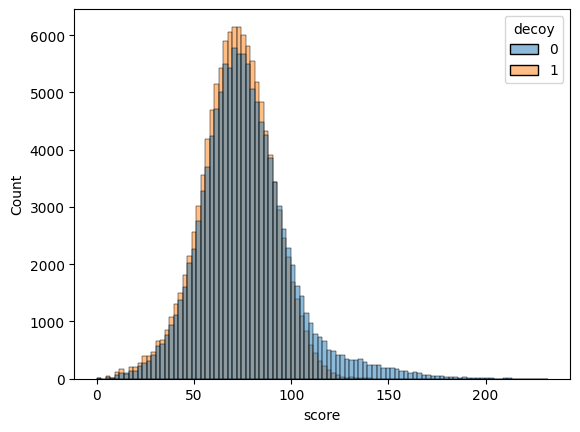

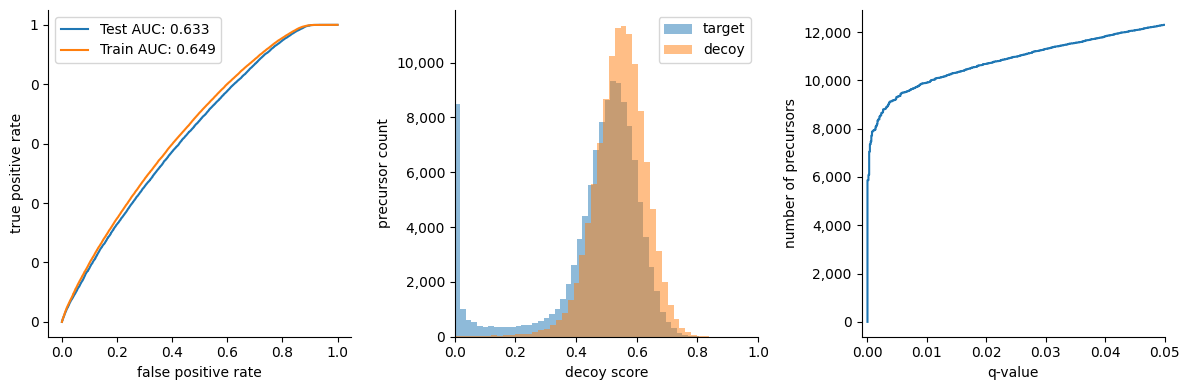

3:30:19.683111 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===


Storing classifier: 8ee73a39647bfdbb


3:30:20.203522 PROGRESS: ============================= Precursor FDR =============================
3:30:20.204732 PROGRESS: Total precursors accumulated: 12,507
3:30:20.205448 PROGRESS: Target precursors: 11,859 (94.82%)
3:30:20.206148 PROGRESS: Decoy precursors: 648 (5.18%)
3:30:20.206982 PROGRESS: 
3:30:20.207627 PROGRESS: Precursor Summary:
3:30:20.264536 PROGRESS: Channel   0:	 0.05 FDR: 11,714; 0.01 FDR: 9,803; 0.001 FDR: 7,892
3:30:20.268041 PROGRESS: 
3:30:20.268823 PROGRESS: Protein Summary:
3:30:20.300767 PROGRESS: Channel   0:	 0.05 FDR: 5,383; 0.01 FDR: 4,747; 0.001 FDR: 4,105
3:30:20.302730 PROGRESS: =========================================================================


fragments_df_filtered: 5000


3:30:22.359157 INFO: calibration group: precursor, fitting mz estimator 


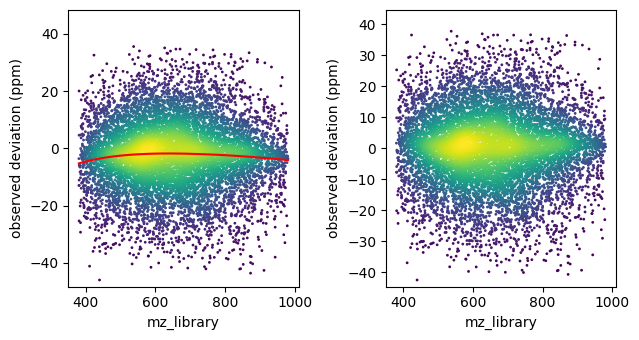

3:30:25.801512 INFO: === checking if epoch conditions were reached ===
3:30:25.803735 INFO:  ms1_error      : 35.9061 > 0.1
3:30:25.805912 INFO: ✅ current_epoch  : 2 >= 2
3:30:25.807533 INFO: ==============================================


score cutoff 35.50049025726318


3:31:06.285368 PROGRESS: Optimal value for ms1 is 69.61.
3:31:12.294419 PROGRESS: Optimal value for mobility is 0.08.


In [38]:
workflow.calibration(param_calibration_order = [['ms2'], ['rt'], ['ms1', 'mobility']])

In [60]:
plotting_df = workflow.com.param_calibration_df.melt(id_vars=['params_being_fitted', 'num_precursors'])

In [68]:
plotting_df = plotting_df[plotting_df.apply(lambda row: row['variable'] in row['params_being_fitted'], axis=1)]

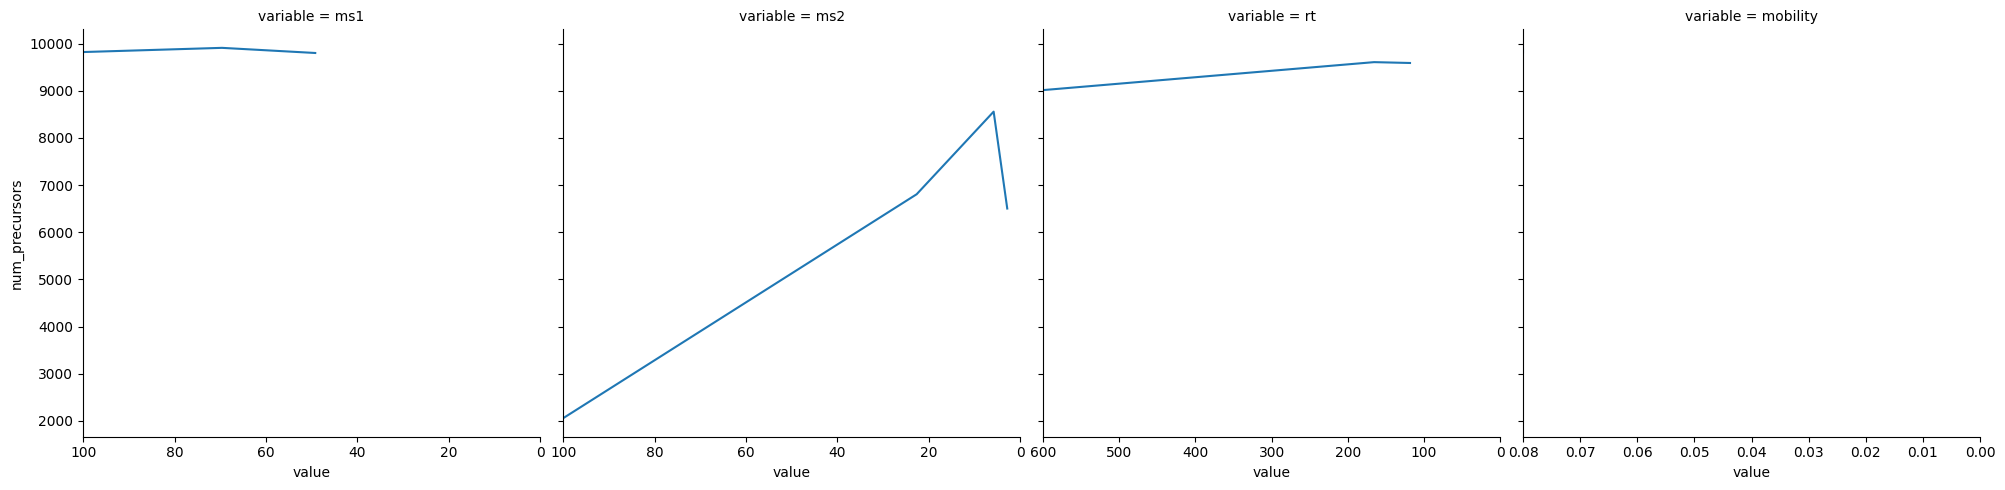

In [85]:
import seaborn as sns

limits = {
    'ms1' : (0, 100),
    'ms2' : (0, 100),
    'rt' : (0, 600), 
    'mobility' : (0, 0.08),
}

g = sns.relplot(plotting_df, x='value', y='num_precursors', col='variable', kind='line', facet_kws={'sharex': 'col'})
for ax, variable_col in zip(g.axes.flat, plotting_df.variable.unique()):
    ax.set_xlim(limits[variable_col])
    ax.invert_xaxis()
plt.savefig('debugging_files/summary_plot.png', dpi=300)
plt.show()



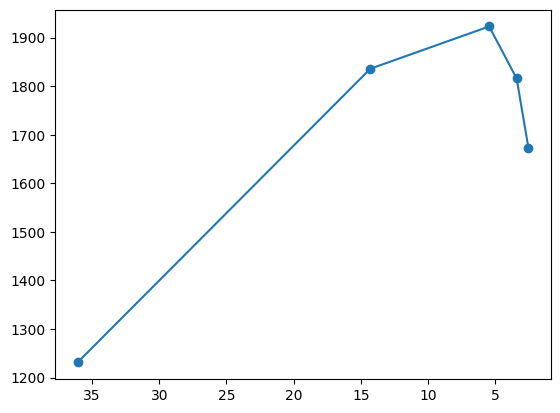

In [91]:
fig, ax = plt.subplots()
ax.plot(workflow.com.ms2_list[1:6], workflow.com.precursor_number[1:6], linestyle='-')
ax.scatter(workflow.com.ms2_list[1:6], workflow.com.precursor_number[1:6])
ax.invert_xaxis()
plt.savefig("debugging_files/ms2_plot.png", dpi=300)
plt.show()

0:46:18.222662 INFO: calibration group: precursor, predicting mz
0:46:18.699327 INFO: calibration group: precursor, predicting rt
0:46:19.212572 INFO: calibration group: fragment, predicting mz
0:46:21.199798 PROGRESS: Extracting batch of 481467 precursors
0:46:22.166090 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
0:46:22.167055 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
0:46:22.168246 INFO: FWHM in RT is 3.06 seconds, sigma is 0.42
0:46:22.168897 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
0:46:22.180865 INFO: Starting candidate selection
100%|██████████| 481467/481467 [03:04<00:00, 2611.28it/s]
0:49:38.518982 INFO: Applying score cutoff of 41.38192577362061
0:49:39.792369 INFO: Removed 624002 precursors with score below cutoff
0:49:43.388250 INFO: Starting candidate scoring
100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s]
0:51:20.960183 INFO: Finished candidate processing
0:51:20.986615 INFO: Collecting candidate features
0:51:41.5

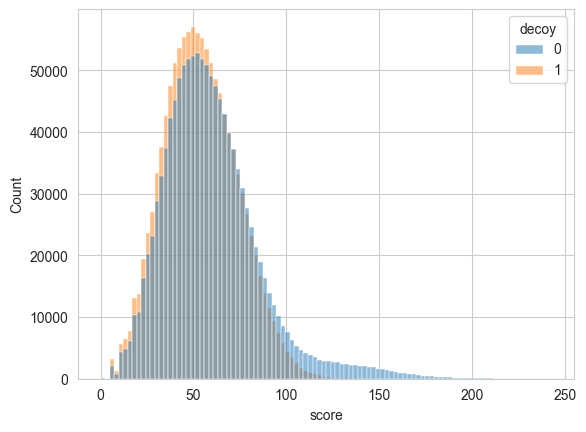

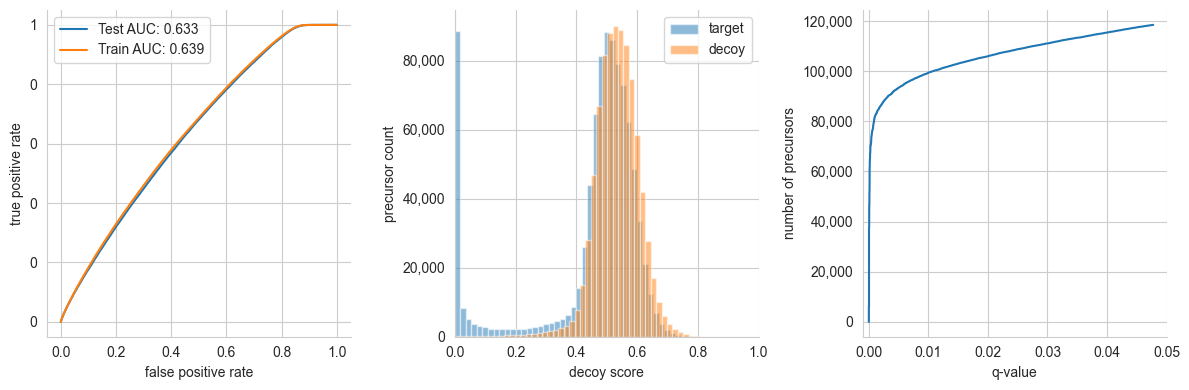

0:53:50.416393 INFO: Removing fragments below FDR threshold
0:53:52.505206 PROGRESS: ============================= Precursor FDR =============================
0:53:52.520319 PROGRESS: Total precursors accumulated: 99,339
0:53:52.521444 PROGRESS: Target precursors: 98,356 (99.01%)
0:53:52.522378 PROGRESS: Decoy precursors: 983 (0.99%)
0:53:52.523137 PROGRESS: 
0:53:52.523748 PROGRESS: Precursor Summary:
0:53:52.596824 PROGRESS: Channel   0:	 0.05 FDR: 98,356; 0.01 FDR: 98,356; 0.001 FDR: 81,618
0:53:52.597826 PROGRESS: 
0:53:52.598484 PROGRESS: Protein Summary:
0:53:52.705212 PROGRESS: Channel   0:	 0.05 FDR: 10,314; 0.01 FDR: 10,314; 0.001 FDR: 9,346
0:53:52.752980 PROGRESS: =========================================================================


(        base_width_mobility  base_width_rt  rt_observed  mobility_observed  \
 71337                   0.0      23.299622   679.788635           0.000001   
 92122                   0.0      20.210022   873.802917           0.000001   
 98268                   0.0      35.635681   796.254944           0.000001   
 26874                   0.0      29.484314   693.778687           0.000001   
 81602                   0.0      20.201294   484.358032           0.000001   
 ...                     ...            ...          ...                ...   
 1300                    0.0      10.838318   797.801331           0.000001   
 100804                  0.0      10.822876   588.340332           0.000001   
 77650                   0.0      13.951904   689.128296           0.000001   
 55103                   0.0      10.815002   654.966003           0.000001   
 110320                  0.0      17.057251   667.354980           0.000001   
 
         mono_ms1_intensity  top_ms1_intensity  su

In [12]:
workflow.extraction()

In [14]:
from alphadia.peakgroup import search  # Changed this; original was from alphadia import hybridselection

config = search.HybridCandidateConfig()
config.update(workflow.config["selection_config"])
config.update(
    {
        "rt_tolerance": workflow.com.rt_error,
        "mobility_tolerance": workflow.com.mobility_error,
        "candidate_count": workflow.com.num_candidates,
        "precursor_mz_tolerance": workflow.com.ms1_error,
        "fragment_mz_tolerance": workflow.com.ms2_error,
        "exclude_shared_ions": workflow.config["search"]["exclude_shared_ions"],
    }
)

extraction = search.HybridCandidateSelection(
    workflow.dia_data.jitclass(),
    test_df,
    workflow.spectral_library.fragment_df,
    config.jitclass(),
    rt_column=f"rt_{workflow.com.column_type}",
    mobility_column=f"mobility_{workflow.com.column_type}",
    precursor_mz_column=f"mz_{workflow.com.column_type}",
    fragment_mz_column=f"mz_{workflow.com.column_type}",
    fwhm_rt=workflow.optimization_manager.fwhm_rt,
    fwhm_mobility=workflow.optimization_manager.fwhm_mobility,
)
candidates_df = extraction(thread_count=workflow.config["general"]["thread_count"])

0:53:56.106614 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
0:53:56.107287 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
0:53:56.108294 INFO: FWHM in RT is 3.06 seconds, sigma is 0.42
0:53:56.108704 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
0:53:56.119786 INFO: Starting candidate selection


KeyError: 'mobility_calibrated'

In [ ]:
from alphadia import plexscoring

config = plexscoring.CandidateConfig()
config.update(workflow.config["scoring_config"])
config.update(
    {
        "precursor_mz_tolerance": workflow.com.ms1_error,
        "fragment_mz_tolerance": workflow.com.ms2_error,
        "exclude_shared_ions": workflow.config["search"]["exclude_shared_ions"],
    }
)

candidate_scoring = plexscoring.CandidateScoring(
    workflow.dia_data.jitclass(),
    workflow.spectral_library._precursor_df,
    workflow.spectral_library._fragment_df,
    config=config,
    rt_column=f"rt_{workflow.com.column_type}",
    mobility_column=f"mobility_{workflow.com.column_type}",
    precursor_mz_column=f"mz_{workflow.com.column_type}",
    fragment_mz_column=f"mz_{workflow.com.column_type}",
)

features_df, fragments_df = candidate_scoring(
    candidates_df,
    thread_count=workflow.config["general"]["thread_count"],
)